In [74]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_N, make_FP_axs, same_stim_trial, take_names, get_filename
from tools_lnd import gen_X_from_model_dir_epoch, gen_trials_from_model_dir, gen_X_from_model_dir

In [75]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','supp','supp_interp_stim')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [103]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'tanh'
w_init = 'randgauss'#'diag'
ruleset = 'lr'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7
seed = '0'
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/' #final
m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

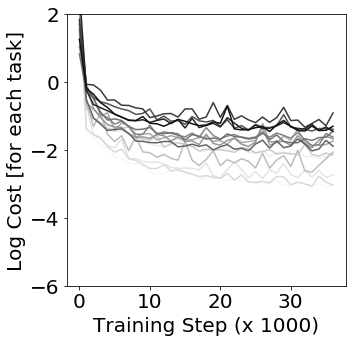

In [104]:
rule_trains = rules_dict['all']
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for ri in range(len(rule_trains)):
    r = rule_trains[ri]
    c = cmap((ri+1)/(len(rule_trains)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+r])
    plt.plot(x,'-',c = c)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
    
# plt.title(m)
plt.show()    

In [105]:
# %matplotlib notebook

In [106]:
# def get_filename(trial, epoch,t):
#     ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
#     nonzero_stim = trial.stim_locs[t,:]<100
#     stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
#     filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

#     return filename, ind_stim_loc

In [107]:
def make_lil_axes(ax,axes_labels,fontsize = 20):
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    [x1,x2] = ax.get_xlim()
    x1 = x1*.8
    x2 = x2*.8
    x_diff = x2-x1
    [y1,y2] = ax.get_ylim()
    y1 = y1*.8
    y2 = y2*.8
    y_diff = y2-y1

    plt.plot([x1,x1+x_diff/10],[y1,y1],'-k')
    plt.plot([x1,x1],[y1,y1+y_diff/10],'-k')
    plt.text(x1,y1-y_diff/10,axes_labels[0],fontsize = fontsize)
    plt.text(x1-x_diff/6,y1+y_diff/10,axes_labels[1],fontsize = fontsize)
    ax.set_yticks([])
    ax.set_xticks([])

In [108]:
def var_ex_X_task(m, rule_ax, rule, epoch_set, batch_size = 1000, 
                  plot_legend = False,fontsize = 20):

    _, rule_name, _, _ = take_names(epoch_set[0],rule)
    _, rule_name_ax, _, _ = take_names(epoch_set[1],rule_ax)

    trial = gen_trials_from_model_dir(m,rule,mode='random',noise_on = False,batch_size = batch_size)
    X, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[0])
    n_components = len(X)-1
    pca = PCA(n_components = n_components)
    _ = pca.fit_transform(X.T)

    trial = gen_trials_from_model_dir(m,rule_ax,mode='random',noise_on = False,batch_size = batch_size)
    X_ax, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[1])
    pca_ax = PCA(n_components = n_components)
    _ = pca_ax.fit_transform(X_ax.T)

    var_same = np.var(np.dot(pca.components_,X),axis = 1)
    var_ax = np.var(np.dot(pca_ax.components_,X),axis = 1)

    fig = plt.figure(figsize=(2.5,4),tight_layout=True,facecolor='white')
    ax = plt.subplot(1,1,1)
    plt.rcParams.update({'font.size': fontsize})
    plt.plot(np.cumsum(var_same)/np.sum(var_same),'-ok',linewidth = 3,markersize = 10,alpha = .2,
             label = 'Same Task PCs')
    plt.plot(np.cumsum(var_ax)/np.sum(var_same),'-o',c = 'mediumorchid', linewidth = 3,markersize = 10,
             alpha = .2,label = 'Other Task PCs')
    
    tick_fontsize = fontsize*.75
    label_fontsize = fontsize*1
    plt.xlabel('N PCs',fontsize = label_fontsize)
    ax.xaxis.set_label_coords(.15, -0.025)
    plt.ylabel(rule_name +'\n Variance Explained',fontsize = label_fontsize)
    plt.ylabel('Variance Explained',fontsize = label_fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([.2,.4,.6,.8,1])
    ax.set_yticklabels([.2,.4,.6,.8,1],fontdict={'fontsize':tick_fontsize})
    ax.set_xticks([n_components - (n_components%100),])
    ax.set_xticklabels([n_components - (n_components%100),],fontdict={'fontsize':tick_fontsize})
    ax.set_ylim([0,1.1])
    ax.set_xlim([-20,n_components+20])

    if plot_legend==True:
        plt.legend()

In [109]:
def plot_task_overlap(m,ri_set,epoch_set = ['stim1','stim1'],tit = [],ri_axs = 0, plot_legend = False,
                      figsize = 4,fontsize = 20):
    fig = plt.figure(figsize=(figsize,figsize),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': fontsize})

    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    axs = 'pca_h'
    rule_str = '_'.join(str(r) for r in rule_set)

    cmap_grad = plt.get_cmap('plasma')
    if ri_axs==1:
        cmap_discrete = ['dimgray','gainsboro']
    else:
        cmap_discrete = ['gainsboro','dimgray']
        
    epoch = epoch_set[ri_axs]
    rule = rule_set[ri_axs]

    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    filename,_ = get_filename(trial,epoch,0)
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
    D_use = make_FP_axs(f, m, rule, epoch, axs = axs, clust = 'False')
    epoch_name, rule_name1, _, _ = take_names(epoch,rule_set[0])
    epoch_name, rule_name2, _, _ = take_names(epoch,rule_set[1])

    for ri in range(2):

        rule = rule_set[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]

        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        x_epoch = np.transpose(x[:,:,(T_inds[0]-1):T_inds[-1]],(1,2,0))

        ax = plt.subplot(111)

        plot_N(x_epoch[trial_set,:,:],D_use.T,trial.stim_locs[trial_set,0],
               linewidth = 18,linestyle = '-', alpha = .1, markersize = 20)
        plot_N(x_epoch[trial_set,:,:],D_use.T,[cmap_discrete[ri],],linewidth = 6, 
               linestyle =  '-', alpha = .9, markersize = 10)

    if len(tit)<1:
        tit = rule_name1+' vs.'+rule_name2
    plt.title(tit,fontsize = fontsize,fontweight='bold')

    tit_save = '_'.join(tit.split())
    make_lil_axes(ax,['PC1','PC2'])

    fig_fldr = '2_task_viz'
    if not os.path.exists(os.path.join(figpath,fig_fldr)):
        os.makedirs(os.path.join(figpath,fig_fldr))

    plt.savefig(os.path.join(figpath,fig_fldr,tit_save+'.pdf'),bbox_inches='tight')
    plt.savefig(os.path.join(figpath,fig_fldr,tit_save+'.png'))
    plt.show()

    var_ex_X_task(m, rule_set[ri_axs], rule_set[1-ri_axs], [epoch_set[1-ri_axs],
                                                                epoch_set[ri_axs]], plot_legend = plot_legend)
    fig_fldr = '2_task_var'
    if not os.path.exists(os.path.join(figpath,fig_fldr)):
        os.makedirs(os.path.join(figpath,fig_fldr))

    plt.savefig(os.path.join(figpath,fig_fldr,tit_save+'.pdf'),bbox_inches='tight')
    plt.savefig(os.path.join(figpath,fig_fldr,tit_save+'.png'))
    plt.show()

In [110]:
from tools_lnd import interp_h_tasks_w_context
def gen_trial_set(ri_set):
    rule1 = rules_dict['all'][ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    return [trial1,trial2]

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(2

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


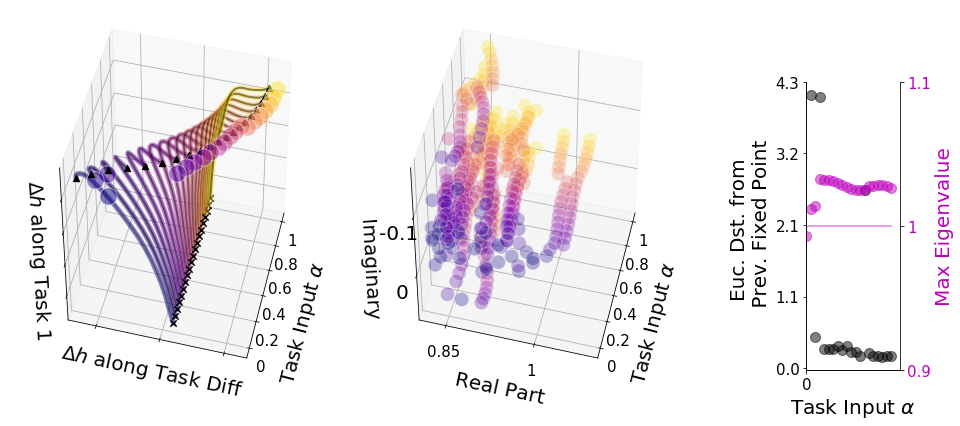

In [111]:
ri_set = [13,14]
epoch_list = ['stim1','stim1']
trial_set = gen_trial_set(ri_set)
interp_h_tasks_w_context(m, ri_set,trial_set,epoch_list,step_file = 'interp_tasks_small_init_stim',
                         fig_width = 13,fig_height = 4, figpath = figpath, trial_num=[20,20])

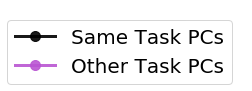

In [112]:
fig = plt.figure(figsize=(1, 1))

ax = plt.subplot(111)
ax.plot(1,1,'-ok',linewidth = 3,markersize = 10,alpha = .9,
         label = 'Same Task PCs')
ax.plot(1,1,'-o',c = 'mediumorchid', linewidth = 3,markersize = 10,
         alpha = .9,label = 'Other Task PCs')
ax.set_xlim([-1,0])
ax.set_ylim([-1,0])
plt.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

fig_fldr = '2_task_var'
if not os.path.exists(os.path.join(figpath,fig_fldr)):
    os.makedirs(os.path.join(figpath,fig_fldr))

plt.savefig(os.path.join(figpath,fig_fldr,'legend.pdf'),bbox_inches='tight')
plt.savefig(os.path.join(figpath,fig_fldr,'legend.png'))
plt.show()

In [113]:
from tools_lnd import interp2d
def var_ex_X_task(m, rule_set, epoch_set, n_components = 200, batch_size = 1000, plot_legend = False):

    rule_name_set = {}
    _, rule_name_set[0], _, _ = take_names(epoch_set[0],rule_set[0])
    _, rule_name_set[1], _, _ = take_names(epoch_set[1],rule_set[1])

    trial = gen_trials_from_model_dir(m,rule_set[0],mode='random',noise_on = False,batch_size = 200)
    X, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[0])
    pca = PCA(n_components = 20)
    _ = pca.fit_transform(X.T)

    trial = gen_trials_from_model_dir(m,rule_set[1],mode='random',noise_on = False,batch_size = 200)
    X_ax, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[1])
    pca_ax = PCA(n_components = 20)
    _ = pca_ax.fit_transform(X_ax.T)

    var_same = np.var(np.dot(pca.components_,X),axis = 1)
    var_ax = np.var(np.dot(pca_ax.components_,X),axis = 1)

    plt.rcParams.update({'font.size': 16})
    plt.plot(np.cumsum(var_same)/np.sum(var_same),'-ok',linewidth = 3,markersize = 10,alpha = .5,
             label = rule_name_set[0] + ' PCs')
    plt.plot(np.cumsum(var_ax)/np.sum(var_same),'-o',c = 'mediumorchid', linewidth = 3,markersize = 10,
             alpha = .5,label = rule_name_set[1] + ' PCs')
    plt.xlabel('N PCs',fontsize = 18)
    ax.xaxis.set_label_coords(.15, -0.025)
    plt.ylabel(rule_name_set[0] +'\n Variance Explained',fontsize = 18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([n_components,])
    ax.set_ylim([0,1.1])
    ax.set_xlim([-.05*n_components,2.5*n_components])
    if plot_legend==True:
        plt.legend(loc='upper center', bbox_to_anchor=(0.01, 1.3))


In [114]:
def get_interp_filename(trial1,trial2,epoch_list,t_set):

    epoch_list = ['stim1','stim1']

    n_stim_per_ring = int(np.shape(trial1.y)[2]-1)
    stim_size = int(2*n_stim_per_ring+1)

    rule1 = rules_dict['all'][np.argmax(trial1.x[0,0,stim_size:])]
    rule2 = rules_dict['all'][np.argmax(trial2.x[0,0,stim_size:])]
    ind_stim_loc1  = 180*trial1.y_loc[-1,t_set[0]]/np.pi
    ind_stim_loc2  = 180*trial2.y_loc[-1,t_set[1]]/np.pi
    filename = rule1+'_'+rule2+'_'+'_'.join(epoch_list)+'_x'+str(round(ind_stim_loc1,2))+'_x'+str(round(ind_stim_loc2,2))

    return filename

def interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov',tol_q = 1e-6,interp = True,
             cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['gainsboro','dimgray'],q_thresh = .001,
            n_skip_interps=2, rule_axs = 0, plot_unstable = True, color_stim = True,figpath = [],fig_size = 4,
            alpha_max = 1.1,fontsize = 20,title_y = .9,set_tit = []):
    
    fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': fontsize})
    n_interp = 20

    epoch = epoch_set[rule_axs]
    epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule_set[0])
    epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule_set[1])
    if epoch_name1==epoch_name2:
        epoch_name = epoch_name1

    if interp:
        if script_name == 'interp_tasks_small_init_stim':
            trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
            r2 = np.where([rules_dict['all'][i]==rule_set[1] for i in range(len(rules_dict['all']))])[0][0]
            trial2 = same_stim_trial(trial1, r2) 
            trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
            filename_interp = get_interp_filename(trial1,trial2,['stim1','stim1'],t_set)
            
        elif script_name == 'interp_tasks_small_init_mov':
            trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
            trial2 = gen_trials_from_model_dir(m,rule_set[1],mode='test',noise_on = False)
            trial2 = same_mov_inds(trial1, trial2) 
            trial1 = gen_trials_from_model_dir(m,rule_set[0],mode='test',noise_on = False)
            filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)

        for step_i in range(n_interp):#[9, 10, 8, 11, 7, 12, 6, 13, 5, 14, 4, 15, 3, 16, 2, 17, 1, 18, 19, 0]:
            c = cmap_grad(step_i/n_interp)

            fp_dir = os.path.join(m,script_name,rule_set[0]+'_'+rule_set[1],'tol_q_e_'+str(-np.log10(tol_q)),
                                  filename_interp+'_step_'+str(step_i)+'.npz')
            fp_struct = np.load(fp_dir)
            step_fps = fp_struct['xstar']
            fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
            J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
            sorted_fps = fp_struct['xstar'][fp_inds,:]
            eig_decomps = comp_eig_decomp(J_xstar)

            for fp_ind in range(len(fp_inds)):

                fp = np.dot(sorted_fps[fp_ind,:],D_use)

                stability_metric = alpha_max - np.max(eig_decomps[fp_ind]['evals'].real)
                facecolors_3d = c
                facecolors_2d = c
                edgecolors = 'w'
                al = stability_metric
                
                if np.max(eig_decomps[fp_ind]['evals'].real)>1:
                    if plot_unstable:
                        plt.plot(fp[0],fp[1],'o',c = edgecolors,linewidth = 10,markersize = 20,markerfacecolor = facecolors_2d,
                                 alpha = stability_metric)

                else:

                    plt.plot(fp[0],fp[1],'o',c = edgecolors,linewidth = 10,markersize = 20,markerfacecolor = facecolors_2d,
                                 alpha = stability_metric)
    
    for ri in range(2):

        rule = rule_set[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]
        trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
        trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/8))

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

        ax = plt.subplot(111)
        stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
        y_locs = trial.y_loc[-1,:]

        if color_stim:
            plot_N( x_epoch[trial_set,:,:],D_use.T,stim1_locs[trial_set],
                   linewidth = fig_size+1,linestyle = '-', alpha = .5, markersize = 20)
        else:
            plot_N(x_epoch[trial_set,:,:],D_use.T,y_locs[trial_set],
                   linewidth = fig_size+1,linestyle = '-', alpha = .5, markersize = 20)

        plot_N(x_epoch[trial_set,:,:],D_use.T,[cmap_discrete[ri],],linewidth = fig_size/2, 
               linestyle =  '-', alpha = .9, markersize = 10)

    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    ax.set_xlim([x1-.2*abs(x1),x2+.2*abs(x2)])
    ax.set_ylim([y1-.2*abs(y1),y2+.2*abs(y2)])
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()

    if len(set_tit)>0:
        tit = set_tit 
        tit_name = set_tit
    elif rule_set[0]==rule_set[1]:
        tit = 'Single Task : '+rule_name1+'\n '+r"$\bf{"+epoch_name1+"}$"+' vs. '+r"$\bf{"+epoch_name2+"}$"+' dynamics' 
        tit_name = rule_name1+'_'+epoch_name1+'_v_'+epoch_name2+'_dynamics_2d'
    else:       
        tit = r"$\bf{"+rule_name1+"}$"+' vs. '+r"$\bf{"+rule_name2+"}$"+ '\n '+epoch_name1+' dynamics'
        tit_name = rule_name1+'_v_'+rule_name2+'_'+epoch_name1+'_dynamics_2d'   
    plt.title(tit,y = title_y)

    _, ax_rule_name, _, _ = take_names(epoch,rule_set[rule_axs])
    axes_label1 = r"$\bf{" + ax_rule_name + "}$"+' \n'+epoch_name1+' PC1'
    axes_label2 = r"$\bf{" + ax_rule_name + "}$"+' \n'+epoch_name1+' PC2'
    make_lil_axes(ax,[axes_label1,axes_label2],fontsize = fontsize)

    fig_fldr = 'interp_fps'
    if not os.path.exists(os.path.join(figpath,fig_fldr,script_name)):
        os.makedirs(os.path.join(figpath,fig_fldr,script_name))

    plt.savefig(os.path.join(figpath,fig_fldr,script_name,tit_name+'.pdf'),bbox_inches='tight')
    plt.savefig(os.path.join(figpath,fig_fldr,script_name,tit_name+'.png'))
    plt.show()

stim1
go1
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0

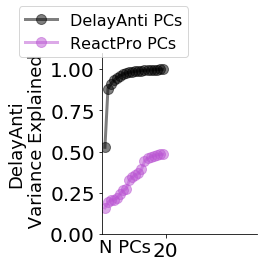

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(2

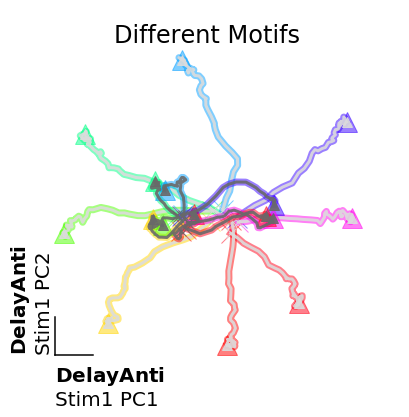

stim1
stim1
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

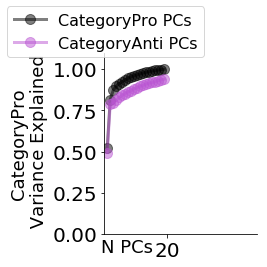

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(2

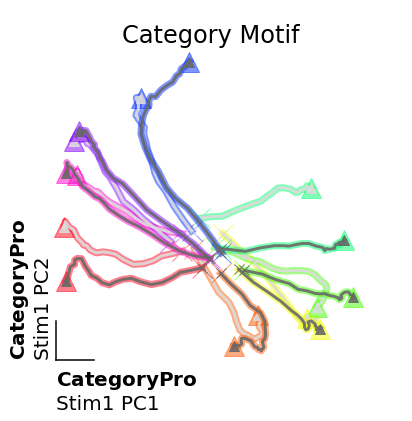

stim1
stim1
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

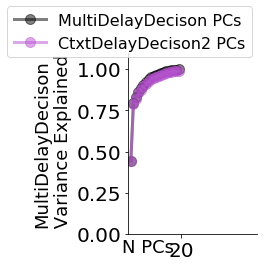

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(2

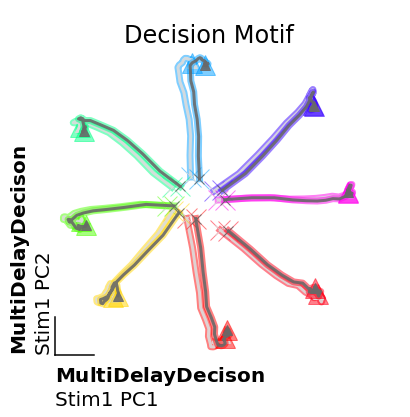

In [115]:
from tools_lnd import comp_eig_decomp, make_lil_axes

ri_sets = [[3,1],[13,14],[10,9]]
epoch_sets = [['stim1','go1'],['stim1','stim1'],['stim1','stim1']]
set_tits = ['Different Motifs','Category Motif','Decision Motif']

for set_i in range(len(ri_sets)):
    ri_set = ri_sets[set_i]
    epoch_set = epoch_sets[set_i]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    set_tit = set_tits[set_i]
    
    fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
    ax = plt.subplot(1,1,1)

    for seed_ind in range(1):
        seed=str(seed_ind)
        m = os.path.join(p,data_folder,'lr',rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

        if seed=='0':
            plot_legend = True
        else:
            plot_legend = False

        var_ex_X_task(m, rule_set, epoch_set,plot_legend = plot_legend, n_components = 20)

    ruleset = rules_dict['all'][ri_set[0]]+'_'+rules_dict['all'][ri_set[1]]
    figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

    fig_fldr = os.path.join(figpath,'var',ruleset)
    if not os.path.exists(fig_fldr):
        os.makedirs(fig_fldr)

    plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
    plt.savefig(os.path.join(fig_fldr,figname+'.png'),bbox_inches = 'tight')
    plt.show()

    seed=str(0)
    m = os.path.join(p,data_folder,'lr',rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)
    
    t_set = [0,0]
    rule = rules_dict['all'][ri_set[0]]
    filename = 'filename'
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
    D_use = make_FP_axs(f, m, rule, epoch_set[0], axs = 'pca_h', clust = 'False')
    
    interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_stim',tol_q = 1e-6,interp = False,
             cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['gainsboro','dimgray'],q_thresh = .000001,
             n_skip_interps=2, rule_axs = 0, plot_unstable = True, color_stim = True,figpath = figpath,fig_size = 6,
             fontsize = 20,title_y = .9,set_tit = set_tit)


In [126]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'GRU'
activation = 'tanh'
w_init = 'diag'#'diag'
ruleset = 'lr'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7
seed = '0'
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/' #final
m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

stim1
go1
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
stim1
go1
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm

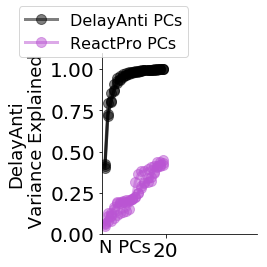

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextd

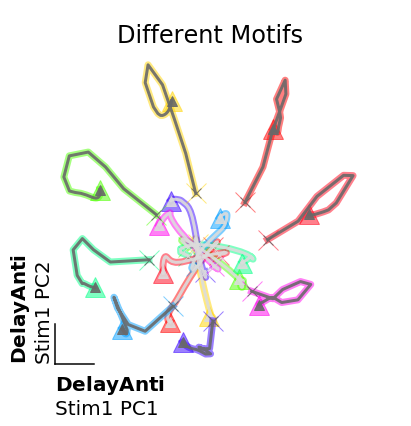

stim1
stim1
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelay

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
stim1
stim1
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelay

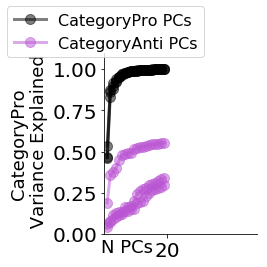

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextd

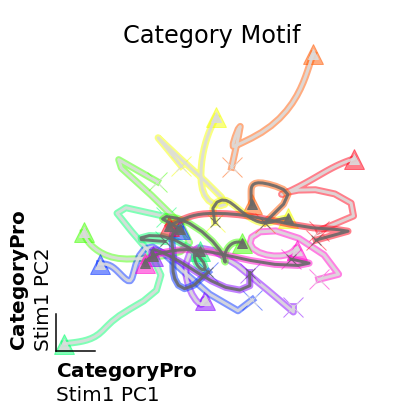

stim1
stim1
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelay

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
stim1
stim1
Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelay

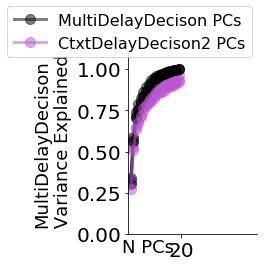

Variables being optimized:
<tf.Variable 'rnn/gru_cell/gates/kernel:0' shape=(281, 512) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/gates/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/gru_cell/candidate/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/GRU/tanh/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextd

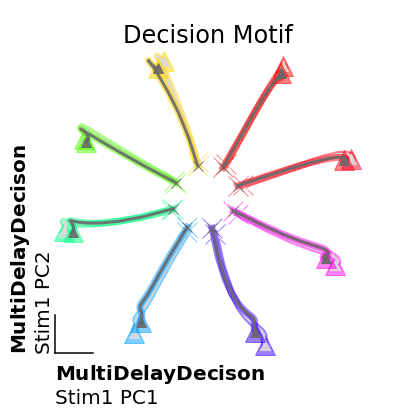

In [127]:
for set_i in range(len(ri_sets)):
    ri_set = ri_sets[set_i]
    epoch_set = epoch_sets[set_i]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    set_tit = set_tits[set_i]
    
    fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
    ax = plt.subplot(1,1,1)

    for seed_ind in range(3):
        seed=str(seed_ind)
        m = os.path.join(p,data_folder,'lr',rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

        if seed=='0':
            plot_legend = True
        else:
            plot_legend = False

        var_ex_X_task(m, rule_set, epoch_set,plot_legend = plot_legend, n_components = 20)

    ruleset = rules_dict['all'][ri_set[0]]+'_'+rules_dict['all'][ri_set[1]]
    figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

    fig_fldr = os.path.join(figpath,'var',ruleset)
    if not os.path.exists(fig_fldr):
        os.makedirs(fig_fldr)

    plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
    plt.savefig(os.path.join(fig_fldr,figname+'.png'),bbox_inches = 'tight')
    plt.show()

    seed=str(0)
    m = os.path.join(p,data_folder,'lr',rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)
    
    t_set = [0,0]
    rule = rules_dict['all'][ri_set[0]]
    filename = 'filename'
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
    D_use = make_FP_axs(f, m, rule, epoch_set[0], axs = 'pca_h', clust = 'False')
    
    interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_stim',tol_q = 1e-6,interp = False,
             cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['gainsboro','dimgray'],q_thresh = .000001,
             n_skip_interps=2, rule_axs = 0, plot_unstable = True, color_stim = True,figpath = figpath,fig_size = 6,
             fontsize = 20,title_y = .9,set_tit = set_tit)


In [131]:
np.max([-1,0])

0

In [128]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'tanh'
w_init = 'randgauss'#'diag'
ruleset = 'lr'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7
seed = '0'
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/' #final
m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

stim1
go1
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/

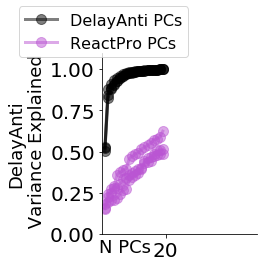

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(2

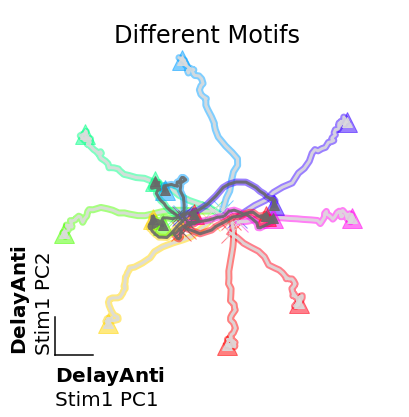

stim1
stim1
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/

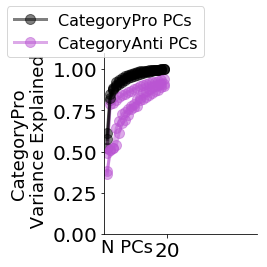

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(2

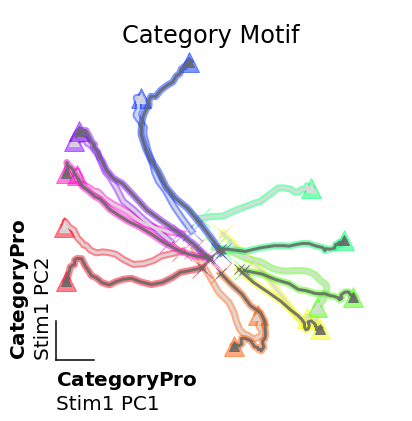

stim1
stim1
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/

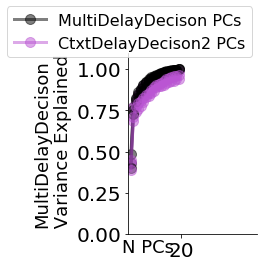

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(2

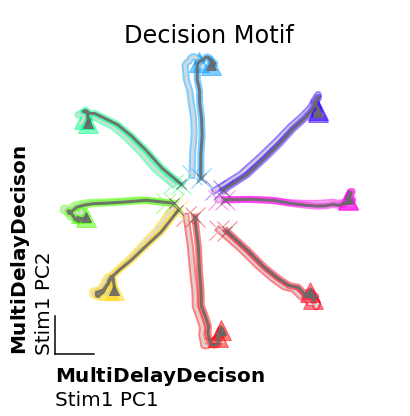

In [129]:
for set_i in range(len(ri_sets)):
    ri_set = ri_sets[set_i]
    epoch_set = epoch_sets[set_i]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    set_tit = set_tits[set_i]
    
    fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
    ax = plt.subplot(1,1,1)

    for seed_ind in range(3):
        seed=str(seed_ind)
        m = os.path.join(p,data_folder,'lr',rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

        if seed=='0':
            plot_legend = True
        else:
            plot_legend = False

        var_ex_X_task(m, rule_set, epoch_set,plot_legend = plot_legend, n_components = 20)

    ruleset = rules_dict['all'][ri_set[0]]+'_'+rules_dict['all'][ri_set[1]]
    figname = 'var_ex_'+ruleset+'_'+'_'.join(rule_set)+'_'.join(epoch_set)

    fig_fldr = os.path.join(figpath,'var',ruleset)
    if not os.path.exists(fig_fldr):
        os.makedirs(fig_fldr)

    plt.savefig(os.path.join(fig_fldr,figname+'.pdf'),bbox_inches = 'tight')
    plt.savefig(os.path.join(fig_fldr,figname+'.png'),bbox_inches = 'tight')
    plt.show()

    seed=str(0)
    m = os.path.join(p,data_folder,'lr',rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)
    
    t_set = [0,0]
    rule = rules_dict['all'][ri_set[0]]
    filename = 'filename'
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
    D_use = make_FP_axs(f, m, rule, epoch_set[0], axs = 'pca_h', clust = 'False')
    
    interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_stim',tol_q = 1e-6,interp = False,
             cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['gainsboro','dimgray'],q_thresh = .000001,
             n_skip_interps=2, rule_axs = 0, plot_unstable = True, color_stim = True,figpath = figpath,fig_size = 6,
             fontsize = 20,title_y = .9,set_tit = set_tit)


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/tanh/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(2

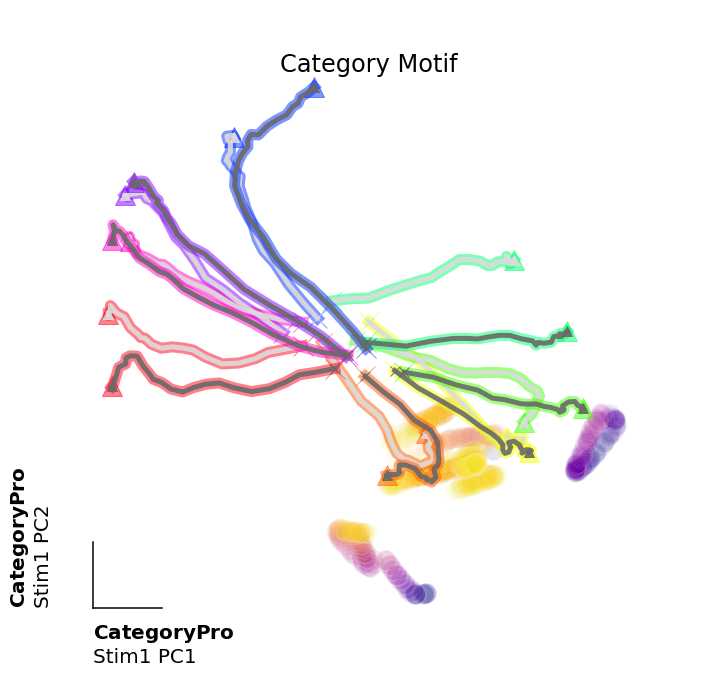

In [123]:
from tools_lnd import comp_eig_decomp, make_lil_axes

ri_sets = [[3,1],[13,14],[10,9]]
epoch_sets = [['stim1','go1'],['stim1','stim1'],['stim1','stim1']]
set_tits = ['Different Motifs','Category Motif','Decision Motif']

for set_i in [1,]:
    ri_set = ri_sets[set_i]
    epoch_set = epoch_sets[set_i]
    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    set_tit = set_tits[set_i]
    
    for seed_ind in range(1):
        seed=str(seed_ind)
        m = os.path.join(p,data_folder,'lr',rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)
    
        t_set = [20,20]
        rule = rules_dict['all'][ri_set[0]]
        filename = 'filename'
        f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
        D_use = make_FP_axs(f, m, rule, epoch_set[0], axs = 'pca_h', clust = 'False')

        interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_stim',tol_q = 1e-6,interp = True,
                 cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['gainsboro','dimgray'],q_thresh = .000001,
                 n_skip_interps=2, rule_axs = 0, plot_unstable = True, color_stim = True,figpath = figpath,fig_size = 10,
                 fontsize = 20,title_y = .9,set_tit = set_tit)
